In [1]:
import torch
import torch.nn as nn
import io
import torch.nn.functional as F
import numpy as np
import time
import math
import datetime
from transformers import AutoModel, AutoTokenizer , AutoConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random


##Set random values
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_val)

In [2]:
import json


data_list = []
file_path = "/kaggle/input/subtaskB_train.jsonl"
with open(file_path, 'r') as file:
    for line in file:
        json_object = json.loads(line)
        data_list.append(json_object)
test_list = []
file_path = "/kaggle/input/subtaskB_dev.jsonl"
with open(file_path, 'r') as file:
    for line in file:
        json_object = json.loads(line)
        test_list.append(json_object)

In [3]:
import pandas as pd

df = pd.DataFrame(data_list)
model_counts = df.groupby('model').size().reset_index(name='Count')
del df
label_map = {}
label_list = list(model_counts.model)
for (i, label) in enumerate(label_list):
    label_map[label] = i
inverted_label_map = {value: key for key, value in label_map.items()}
display(model_counts)

,model,Count
0,bloomz,11998
1,chatGPT,11995
2,cohere,11336
3,davinci,11999
4,dolly,11702
5,human,11997


In [4]:
# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [5]:
from torch.utils.data import Dataset, DataLoader
import random

class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length= 128 , percentage = 0.01):
        random.shuffle(data)
        self.data = data[: int( percentage * len(data))]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]['text']
        label = label_map[self.data[idx]['model']]

        # Tokenize input text
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Convert label to tensor
        label_tensor = torch.tensor(label)
        
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'label': label_tensor
        }

In [6]:
import gc
torch.cuda.empty_cache()
# del model, org_image, changed_image, labels
gc.collect()

69

In [10]:
from transformers import AdamW, BertConfig, BertForSequenceClassification, BertTokenizer
from sklearn.metrics import accuracy_score,f1_score, classification_report
import time
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
### Deffine Bert Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
### Hyper Parameters 
percentages = [0.01, 0.05, 0.1, 0.5]
batch_size = 16
num_epochs = 10
printer_controler = 0
accuracies = []
best_accuracy = 0
weighted_f1s = []
best_weighted_f1 = 0
num_workers = 2
### Using 1,5,10,50 %  of Training Data
for percentage in percentages:
    printer_controler += 1 
    print("#"* 80)
    print(f"\033[1m Percentage of training data = {percentage * 100 } % \033[0m") 
    ### Load Bert classifier and optimizer 
    model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 6 ).to(device)
    optimizer = AdamW(model.parameters(), lr=1e-5)
    max_length = 256
    ### Define Train and Validation Dataset
    train_dataset = CustomDataset(data_list, tokenizer = tokenizer, max_length = max_length, percentage = percentage )
    test_dataset = CustomDataset(test_list, tokenizer = tokenizer, max_length = max_length, percentage = 1)
    # Create Train & Validation DataLoader 
    dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
    
    # Training loop
    ### Calculate Time
    start_time = time.time() 
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        train_labels = []
        train_predictions = []
        for (idx,batch) in enumerate(dataloader):
            ### Using Gpu Device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            optimizer.zero_grad()
            ### Define loss of Classifier and EBP
            loss = model(input_ids = input_ids ,attention_mask = attention_mask , labels = labels).loss
            outputs = model(input_ids = input_ids ,attention_mask = attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            ### Calculate Accuracy on Train Data
            train_labels.extend(labels.cpu().numpy())
            train_predictions.extend(predictions.cpu().numpy())
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            if (idx+1) % ( 10 * printer_controler )  == 0 :
                end_time = time.time()  
                training_time = end_time - start_time 
                training_time = str(datetime.timedelta(seconds=int(training_time)))
                print(f"Epoch = {epoch+1}, Iteration = {idx + 1 }/ {len(dataloader)}  ===> Average training loss = , {'{:.3f}'.format(total_loss/(idx )) }, Training Time: {training_time}" ) 
        
        train_accuracy = accuracy_score(train_labels, train_predictions)

        print(f"Epoch = {epoch+1} ===> training_accuracy ={'{:.3f}'.format(train_accuracy) } " )
        
        model.eval()
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for batch in valid_dataloader:
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=1)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
            accuracy = accuracy_score(all_labels, all_predictions)
            best_accuracy = max(accuracy, best_accuracy)
            if accuracy == best_accuracy :
                output_dir = f"/kaggle/working/best_model_for_{percentage*100}_percentage"
                model.save_pretrained(output_dir)
        weighted_f1 = f1_score(all_labels, all_predictions, average='weighted')
        print(f'Weighted F1 Score: {weighted_f1:.4f}')
        best_weighted_f1 = max(weighted_f1, best_weighted_f1)
        f1_per_class = f1_score(all_labels, all_predictions, average = None)
        print(f"\033[1mEpoch = {epoch+1} ====> Accuracy On Validation Dataset={'{:.3f}'.format(accuracy) }\033[0m")
        
        for class_idx, f1 in enumerate(f1_per_class):
            print(f'F1 Score (Class {inverted_label_map[class_idx]}): {f1:.4f}')
        print()
    accuracies.append(best_accuracy)
    weighted_f1s.append(best_weighted_f1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

################################################################################
 Percentage of training data = 1.0 % 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch = 1, Iteration = 10/ 45  ===> Average training loss = , 2.025, Training Time: 0:00:06
Epoch = 1, Iteration = 20/ 45  ===> Average training loss = , 1.915, Training Time: 0:00:11
Epoch = 1, Iteration = 30/ 45  ===> Average training loss = , 1.878, Training Time: 0:00:16
Epoch = 1, Iteration = 40/ 45  ===> Average training loss = , 1.851, Training Time: 0:00:21
Epoch = 1 ===> training_accuracy =0.182 
Weighted F1 Score: 0.2283
Epoch = 1 ====> Accuracy On Validation Dataset=0.305
F1 Score (Class bloomz): 0.5090
F1 Score (Class chatGPT): 0.3951
F1 Score (Class cohere): 0.2342
F1 Score (Class davinci): 0.2006
F1 Score (Class dolly): 0.0000
F1 Score (Class human): 0.0311

Epoch = 2, Iteration = 10/ 45  ===> Average training loss = , 1.920, Training Time: 0:01:16
Epoch = 2, Iteration = 20/ 45  ===> Average training loss = , 1.796, Training Time: 0:01:21
Epoch = 2, Iteration = 30/ 45  ===> Average training loss = , 1.758, Training Time: 0:01:26
Epoch = 2, Iteration = 40/ 45  ===> Average

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch = 1, Iteration = 20/ 222  ===> Average training loss = , 1.949, Training Time: 0:00:10
Epoch = 1, Iteration = 40/ 222  ===> Average training loss = , 1.866, Training Time: 0:00:20
Epoch = 1, Iteration = 60/ 222  ===> Average training loss = , 1.833, Training Time: 0:00:30
Epoch = 1, Iteration = 80/ 222  ===> Average training loss = , 1.805, Training Time: 0:00:40
Epoch = 1, Iteration = 100/ 222  ===> Average training loss = , 1.776, Training Time: 0:00:50
Epoch = 1, Iteration = 120/ 222  ===> Average training loss = , 1.747, Training Time: 0:01:00
Epoch = 1, Iteration = 140/ 222  ===> Average training loss = , 1.717, Training Time: 0:01:10
Epoch = 1, Iteration = 160/ 222  ===> Average training loss = , 1.692, Training Time: 0:01:20
Epoch = 1, Iteration = 180/ 222  ===> Average training loss = , 1.659, Training Time: 0:01:31
Epoch = 1, Iteration = 200/ 222  ===> Average training loss = , 1.624, Training Time: 0:01:41
Epoch = 1, Iteration = 220/ 222  ===> Average training loss = , 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch = 1, Iteration = 30/ 444  ===> Average training loss = , 1.858, Training Time: 0:00:15
Epoch = 1, Iteration = 60/ 444  ===> Average training loss = , 1.783, Training Time: 0:00:30
Epoch = 1, Iteration = 90/ 444  ===> Average training loss = , 1.730, Training Time: 0:00:45
Epoch = 1, Iteration = 120/ 444  ===> Average training loss = , 1.686, Training Time: 0:01:00
Epoch = 1, Iteration = 150/ 444  ===> Average training loss = , 1.642, Training Time: 0:01:15
Epoch = 1, Iteration = 180/ 444  ===> Average training loss = , 1.592, Training Time: 0:01:30
Epoch = 1, Iteration = 210/ 444  ===> Average training loss = , 1.538, Training Time: 0:01:46
Epoch = 1, Iteration = 240/ 444  ===> Average training loss = , 1.491, Training Time: 0:02:01
Epoch = 1, Iteration = 270/ 444  ===> Average training loss = , 1.442, Training Time: 0:02:16
Epoch = 1, Iteration = 300/ 444  ===> Average training loss = , 1.399, Training Time: 0:02:31
Epoch = 1, Iteration = 330/ 444  ===> Average training loss = ,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch = 1, Iteration = 40/ 2220  ===> Average training loss = , 1.829, Training Time: 0:00:20
Epoch = 1, Iteration = 80/ 2220  ===> Average training loss = , 1.785, Training Time: 0:00:40
Epoch = 1, Iteration = 120/ 2220  ===> Average training loss = , 1.717, Training Time: 0:01:00
Epoch = 1, Iteration = 160/ 2220  ===> Average training loss = , 1.640, Training Time: 0:01:20
Epoch = 1, Iteration = 200/ 2220  ===> Average training loss = , 1.558, Training Time: 0:01:40
Epoch = 1, Iteration = 240/ 2220  ===> Average training loss = , 1.483, Training Time: 0:02:01
Epoch = 1, Iteration = 280/ 2220  ===> Average training loss = , 1.417, Training Time: 0:02:21
Epoch = 1, Iteration = 320/ 2220  ===> Average training loss = , 1.367, Training Time: 0:02:41
Epoch = 1, Iteration = 360/ 2220  ===> Average training loss = , 1.311, Training Time: 0:03:01
Epoch = 1, Iteration = 400/ 2220  ===> Average training loss = , 1.257, Training Time: 0:03:21
Epoch = 1, Iteration = 440/ 2220  ===> Average train

### PLot Validation Accuracies and Weighted F1 Scores

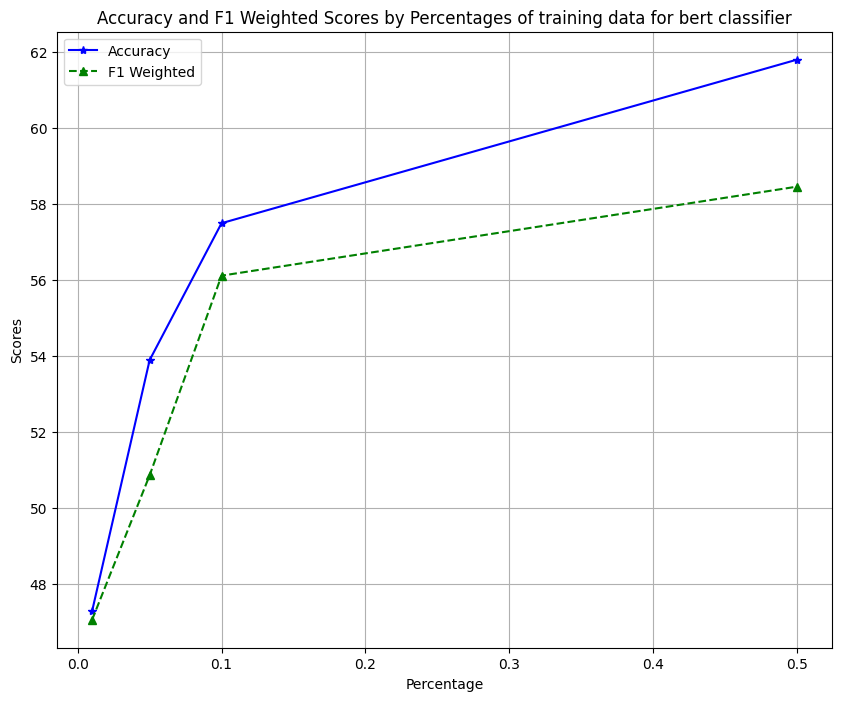

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

# Plot accuracy scores with lines and star markers
ax.plot(percentages, [100*i for i in accuracies], linestyle='-', marker='*', color='blue', label='Accuracy')

# Plot F1 weighted scores with lines and star markers
ax.plot(percentages, [100*i for i in weighted_f1s], linestyle='--', marker='^', color='green', label='F1 Weighted')

# Add labels, legend, and show the plot
ax.set_ylabel('Scores')
ax.set_xlabel('Percentage')
ax.legend()
plt.title('Accuracy and F1 Weighted Scores by Percentages of training data for bert classifier')
plt.grid("on")
plt.show()


### Define Adapter Model

In [8]:
from transformers import BertModel,BertForSequenceClassification
class AdapterLayer(nn.Module):
    def __init__(self, input_size, adapter_size):
        super(AdapterLayer, self).__init__()
        self.down_project = nn.Linear(input_size, adapter_size)
        self.up_project = nn.Linear(adapter_size, input_size)

    def forward(self, x):
        down_projected = self.down_project(x)
        activated = nn.functional.relu(down_projected)
        up_projected = self.up_project(activated)
        return x + up_projected

class BertWithAdapters(BertModel):
    def __init__(self, config):
        super(BertWithAdapters, self).__init__(config)
        self.adapters = nn.ModuleList([AdapterLayer(config.hidden_size, adapter_size=64) for _ in range(config.num_hidden_layers)])
        self.logit = nn.Linear(768, 6)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = super().forward(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state

        for adapter_layer in self.adapters:
            sequence_output = adapter_layer(sequence_output)
        output = sequence_output.mean(dim = 1 )
        output = self.logit(output)
        return self.softmax(output)

### Bert Classifier With Adapter

In [9]:
from transformers import AdamW, BertConfig, BertForSequenceClassification, BertTokenizer
from sklearn.metrics import accuracy_score,f1_score, classification_report
import time
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
### Deffine Bert Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
criterion = nn.CrossEntropyLoss()
### Hyper Parameters 
percentages = [0.01, 0.05, 0.1, 0.5]
batch_size = 16
num_epochs = 10
printer_controler = 0
accuracies = []
best_accuracy = 0
weighted_f1s = []
best_weighted_f1 = 0
num_workers = 2
### Using 1,5,10,50 %  of Training Data
for percentage in percentages:
    printer_controler += 1 
    print("#"* 80)
    print(f"\033[1m Percentage of training data = {percentage * 100 } % \033[0m") 
    ### Load Bert classifier and optimizer 
    model = BertWithAdapters.from_pretrained('bert-base-cased', num_labels = 6 ).to(device)
    optimizer = AdamW(model.parameters(), lr=1e-5)
    max_length = 256
    ### Define Train and Validation Dataset
    train_dataset = CustomDataset(data_list, tokenizer = tokenizer, max_length = max_length, percentage = percentage )
    test_dataset = CustomDataset(test_list, tokenizer = tokenizer, max_length = max_length, percentage = 1)
    # Create Train & Validation DataLoader 
    dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
    
    # Training loop
    ### Calculate Time
    start_time = time.time() 
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        train_labels = []
        train_predictions = []
        for (idx,batch) in enumerate(dataloader):
            ### Using Gpu Device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            optimizer.zero_grad()
            ### Define loss of Classifier and EBP
            outputs = model(input_ids = input_ids ,attention_mask = attention_mask)
            predictions = torch.argmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            ### Calculate Accuracy on Train Data
            train_labels.extend(labels.cpu().numpy())
            train_predictions.extend(predictions.cpu().numpy())
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            if (idx+1) % ( 10 * printer_controler )  == 0 :
                end_time = time.time()  
                training_time = end_time - start_time 
                training_time = str(datetime.timedelta(seconds=int(training_time)))
                print(f"Epoch = {epoch+1}, Iteration = {idx + 1 }/ {len(dataloader)}  ===> Average training loss = , {'{:.3f}'.format(total_loss/(idx )) }, Training Time: {training_time}" ) 
        
        train_accuracy = accuracy_score(train_labels, train_predictions)

        print(f"Epoch = {epoch+1} ===> training_accuracy ={'{:.3f}'.format(train_accuracy) } " )
        
        model.eval()
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for batch in valid_dataloader:
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                predictions = torch.argmax(outputs, dim=1)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
            accuracy = accuracy_score(all_labels, all_predictions)
            best_accuracy = max(accuracy, best_accuracy)
            if accuracy == best_accuracy :
                output_dir = f"/kaggle/working/best_model_for_{percentage*100}_percentage"
                model.save_pretrained(output_dir)
        weighted_f1 = f1_score(all_labels, all_predictions, average='weighted')
        print(f'Weighted F1 Score: {weighted_f1:.4f}')
        best_weighted_f1 = max(weighted_f1, best_weighted_f1)
        f1_per_class = f1_score(all_labels, all_predictions, average = None)
        print(f"\033[1mEpoch = {epoch+1} ====> Accuracy On Validation Dataset={'{:.3f}'.format(accuracy) }\033[0m")
        
        for class_idx, f1 in enumerate(f1_per_class):
            print(f'F1 Score (Class {inverted_label_map[class_idx]}): {f1:.4f}')
        print()
    accuracies.append(best_accuracy)
    weighted_f1s.append(best_weighted_f1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

################################################################################
 Percentage of training data = 1.0 % 


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertWithAdapters were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['bert.adapters.0.down_project.bias', 'bert.adapters.0.down_project.weight', 'bert.adapters.0.up_project.bias', 'bert.adapters.0.up_project.weight', 'bert.adapters.1.down_project.bias', 'bert.adapters.1.down_project.weight', 'bert.adapters.1.up_project.bias', 'bert.adapters.1.up_project.weight', 'bert.adapters.10.down_project.bias', 'bert.adapters.10.down_project.weight', 'bert.adapters.10.up_project.bias', 'bert.adapters.10.up_project.weight', 'bert.adapters.11.down_project.bias', 'bert.adapters.11.down_project.weight', 'bert.adapters.11.up_project.bias', 'bert.adapters.11.up_project.weight', 'bert.adapters.2.down_project.bias', 'bert.adapters.2.down_project.weight', 'bert.adapters.2.up_project.bias', 'bert.adapters.2.up_project.weight', 'bert.adapters.3.down_project.bias', 'bert.adapters.3.down_project.weight', 'bert.adapters.3.up_project.bias', 'bert.adapters

Epoch = 1, Iteration = 10/ 45  ===> Average training loss = , 1.989, Training Time: 0:00:05
Epoch = 1, Iteration = 20/ 45  ===> Average training loss = , 1.886, Training Time: 0:00:09
Epoch = 1, Iteration = 30/ 45  ===> Average training loss = , 1.850, Training Time: 0:00:13
Epoch = 1, Iteration = 40/ 45  ===> Average training loss = , 1.835, Training Time: 0:00:16
Epoch = 1 ===> training_accuracy =0.179 
Weighted F1 Score: 0.0529
Epoch = 1 ====> Accuracy On Validation Dataset=0.156
F1 Score (Class bloomz): 0.0310
F1 Score (Class chatGPT): 0.0040
F1 Score (Class cohere): 0.0157
F1 Score (Class davinci): 0.0000
F1 Score (Class dolly): 0.0000
F1 Score (Class human): 0.2667

Epoch = 2, Iteration = 10/ 45  ===> Average training loss = , 1.968, Training Time: 0:01:11
Epoch = 2, Iteration = 20/ 45  ===> Average training loss = , 1.853, Training Time: 0:01:15
Epoch = 2, Iteration = 30/ 45  ===> Average training loss = , 1.813, Training Time: 0:01:19
Epoch = 2, Iteration = 40/ 45  ===> Average

Some weights of BertWithAdapters were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['bert.adapters.0.down_project.bias', 'bert.adapters.0.down_project.weight', 'bert.adapters.0.up_project.bias', 'bert.adapters.0.up_project.weight', 'bert.adapters.1.down_project.bias', 'bert.adapters.1.down_project.weight', 'bert.adapters.1.up_project.bias', 'bert.adapters.1.up_project.weight', 'bert.adapters.10.down_project.bias', 'bert.adapters.10.down_project.weight', 'bert.adapters.10.up_project.bias', 'bert.adapters.10.up_project.weight', 'bert.adapters.11.down_project.bias', 'bert.adapters.11.down_project.weight', 'bert.adapters.11.up_project.bias', 'bert.adapters.11.up_project.weight', 'bert.adapters.2.down_project.bias', 'bert.adapters.2.down_project.weight', 'bert.adapters.2.up_project.bias', 'bert.adapters.2.up_project.weight', 'bert.adapters.3.down_project.bias', 'bert.adapters.3.down_project.weight', 'bert.adapters.3.up_project.bias', 'bert.adapters

Epoch = 1, Iteration = 20/ 222  ===> Average training loss = , 1.884, Training Time: 0:00:08
Epoch = 1, Iteration = 40/ 222  ===> Average training loss = , 1.832, Training Time: 0:00:15
Epoch = 1, Iteration = 60/ 222  ===> Average training loss = , 1.813, Training Time: 0:00:23
Epoch = 1, Iteration = 80/ 222  ===> Average training loss = , 1.796, Training Time: 0:00:31
Epoch = 1, Iteration = 100/ 222  ===> Average training loss = , 1.767, Training Time: 0:00:39
Epoch = 1, Iteration = 120/ 222  ===> Average training loss = , 1.741, Training Time: 0:00:46
Epoch = 1, Iteration = 140/ 222  ===> Average training loss = , 1.712, Training Time: 0:00:54
Epoch = 1, Iteration = 160/ 222  ===> Average training loss = , 1.686, Training Time: 0:01:02
Epoch = 1, Iteration = 180/ 222  ===> Average training loss = , 1.663, Training Time: 0:01:10
Epoch = 1, Iteration = 200/ 222  ===> Average training loss = , 1.645, Training Time: 0:01:17
Epoch = 1, Iteration = 220/ 222  ===> Average training loss = , 

Some weights of BertWithAdapters were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['bert.adapters.0.down_project.bias', 'bert.adapters.0.down_project.weight', 'bert.adapters.0.up_project.bias', 'bert.adapters.0.up_project.weight', 'bert.adapters.1.down_project.bias', 'bert.adapters.1.down_project.weight', 'bert.adapters.1.up_project.bias', 'bert.adapters.1.up_project.weight', 'bert.adapters.10.down_project.bias', 'bert.adapters.10.down_project.weight', 'bert.adapters.10.up_project.bias', 'bert.adapters.10.up_project.weight', 'bert.adapters.11.down_project.bias', 'bert.adapters.11.down_project.weight', 'bert.adapters.11.up_project.bias', 'bert.adapters.11.up_project.weight', 'bert.adapters.2.down_project.bias', 'bert.adapters.2.down_project.weight', 'bert.adapters.2.up_project.bias', 'bert.adapters.2.up_project.weight', 'bert.adapters.3.down_project.bias', 'bert.adapters.3.down_project.weight', 'bert.adapters.3.up_project.bias', 'bert.adapters

Epoch = 1, Iteration = 30/ 444  ===> Average training loss = , 1.850, Training Time: 0:00:11
Epoch = 1, Iteration = 60/ 444  ===> Average training loss = , 1.812, Training Time: 0:00:23
Epoch = 1, Iteration = 90/ 444  ===> Average training loss = , 1.790, Training Time: 0:00:35
Epoch = 1, Iteration = 120/ 444  ===> Average training loss = , 1.748, Training Time: 0:00:46
Epoch = 1, Iteration = 150/ 444  ===> Average training loss = , 1.703, Training Time: 0:00:58
Epoch = 1, Iteration = 180/ 444  ===> Average training loss = , 1.670, Training Time: 0:01:10
Epoch = 1, Iteration = 210/ 444  ===> Average training loss = , 1.636, Training Time: 0:01:21
Epoch = 1, Iteration = 240/ 444  ===> Average training loss = , 1.614, Training Time: 0:01:33
Epoch = 1, Iteration = 270/ 444  ===> Average training loss = , 1.597, Training Time: 0:01:44
Epoch = 1, Iteration = 300/ 444  ===> Average training loss = , 1.579, Training Time: 0:01:56
Epoch = 1, Iteration = 330/ 444  ===> Average training loss = ,

Some weights of BertWithAdapters were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['bert.adapters.0.down_project.bias', 'bert.adapters.0.down_project.weight', 'bert.adapters.0.up_project.bias', 'bert.adapters.0.up_project.weight', 'bert.adapters.1.down_project.bias', 'bert.adapters.1.down_project.weight', 'bert.adapters.1.up_project.bias', 'bert.adapters.1.up_project.weight', 'bert.adapters.10.down_project.bias', 'bert.adapters.10.down_project.weight', 'bert.adapters.10.up_project.bias', 'bert.adapters.10.up_project.weight', 'bert.adapters.11.down_project.bias', 'bert.adapters.11.down_project.weight', 'bert.adapters.11.up_project.bias', 'bert.adapters.11.up_project.weight', 'bert.adapters.2.down_project.bias', 'bert.adapters.2.down_project.weight', 'bert.adapters.2.up_project.bias', 'bert.adapters.2.up_project.weight', 'bert.adapters.3.down_project.bias', 'bert.adapters.3.down_project.weight', 'bert.adapters.3.up_project.bias', 'bert.adapters

Epoch = 1, Iteration = 40/ 2220  ===> Average training loss = , 1.832, Training Time: 0:00:15
Epoch = 1, Iteration = 80/ 2220  ===> Average training loss = , 1.789, Training Time: 0:00:31
Epoch = 1, Iteration = 120/ 2220  ===> Average training loss = , 1.733, Training Time: 0:00:46
Epoch = 1, Iteration = 160/ 2220  ===> Average training loss = , 1.690, Training Time: 0:01:02
Epoch = 1, Iteration = 200/ 2220  ===> Average training loss = , 1.647, Training Time: 0:01:17
Epoch = 1, Iteration = 240/ 2220  ===> Average training loss = , 1.619, Training Time: 0:01:33
Epoch = 1, Iteration = 280/ 2220  ===> Average training loss = , 1.588, Training Time: 0:01:48
Epoch = 1, Iteration = 320/ 2220  ===> Average training loss = , 1.563, Training Time: 0:02:04
Epoch = 1, Iteration = 360/ 2220  ===> Average training loss = , 1.544, Training Time: 0:02:19
Epoch = 1, Iteration = 400/ 2220  ===> Average training loss = , 1.525, Training Time: 0:02:35
Epoch = 1, Iteration = 440/ 2220  ===> Average train

### PLot Validation Accuracies and Weighted F1 Scores with Adapters

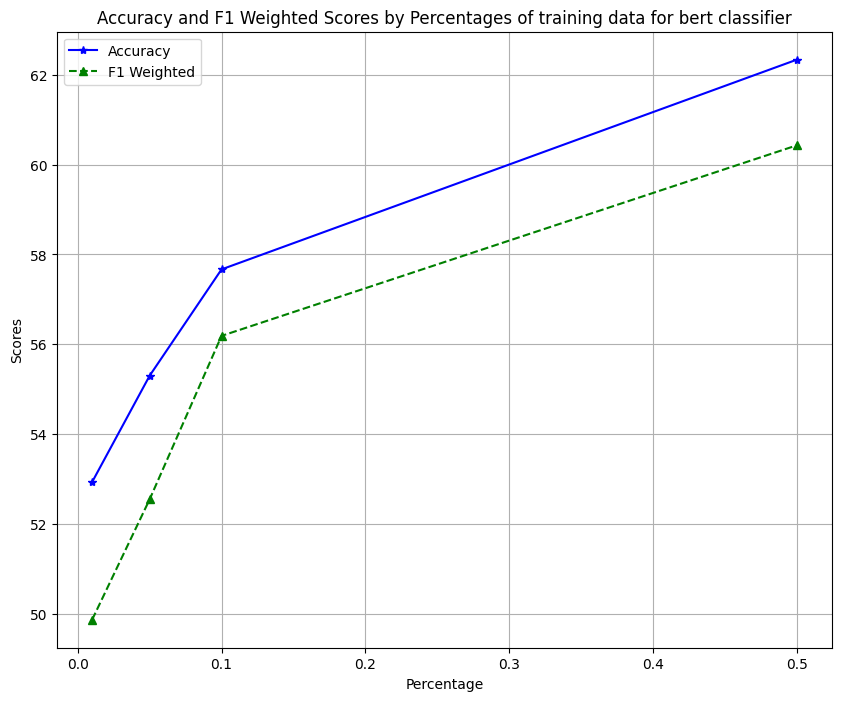

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

# Plot accuracy scores with lines and star markers
ax.plot(percentages, [100*i for i in accuracies], linestyle='-', marker='*', color='blue', label='Accuracy')

# Plot F1 weighted scores with lines and star markers
ax.plot(percentages, [100*i for i in weighted_f1s], linestyle='--', marker='^', color='green', label='F1 Weighted')

# Add labels, legend, and show the plot
ax.set_ylabel('Scores')
ax.set_xlabel('Percentage')
ax.legend()
plt.title('Accuracy and F1 Weighted Scores by Percentages of training data for bert classifier')
plt.grid("on")
plt.show()
